In [2]:
import numpy as np
from tqdm import tqdm
import torch
import torch.autograd as autograd
import torch.nn.functional as F
import torch.nn as nn

In [3]:
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


(60000, 28, 28)
(10000, 28, 28)


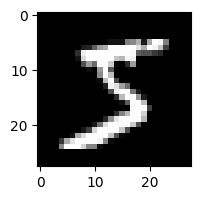

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
print(x_train.shape)
print(x_test.shape)
plt.figure(figsize = (2,2))
plt.imshow(x_train[0], cmap="gray")

In [5]:
#shuffle the dataset
indices = np.arange(x_train.shape[0])
np.random.shuffle(indices)
x_train = x_train[indices]
y_train = y_train[indices]

In [6]:
# add 1 dimension for each channels(=1) in the image
x_train = x_train.reshape(x_train.shape[0],1, 28, 28)
x_test = x_test.reshape(x_test.shape[0], 1, 28, 28)
x_train.shape, x_test.shape

((60000, 1, 28, 28), (10000, 1, 28, 28))

In [7]:
def batchify_data(x_data, y_data, batch_size):
    """Takes a set of data points and labels and groups them into batches."""
    # Only take batch_size chunks (i.e. drop the remainder)
    N = int(len(x_data) / batch_size) * batch_size
    batches = []
    for i in range(0, N, batch_size):
        batches.append({
            'x': torch.tensor(x_data[i:i+batch_size], dtype = torch.float32),
            'y': torch.tensor(y_data[i:i+batch_size], dtype = torch.long)})
    return batches

def compute_accuracy(predictions, y):
    """Computes the accuracy of predictions against the gold labels, y."""
    return np.mean(np.equal(predictions.numpy(), y.numpy()))

In [8]:
def run_epoch(data, model, optimizer):
    """Train model for one pass of train data, and return loss, acccuracy"""
    # Gather losses
    losses = []
    batch_accuracies = []

    # If model is in train mode, use optimizer.
    is_training = model.training

    # Iterate through batches
    for batch in tqdm(data):
        # Grab x and y
        x, y = batch['x'], batch['y']

        # Get output predictions
        out = model(x)

        # Predict and store accuracy
        predictions = torch.argmax(out, dim=1)
        batch_accuracies.append(compute_accuracy(predictions, y))

        # Compute loss
        loss = F.cross_entropy(out, y)
        losses.append(loss.data.item())

        # If training, do an update.
        if is_training:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    # Calculate epoch level scores
    avg_loss = np.mean(losses)
    avg_accuracy = np.mean(batch_accuracies)
    return avg_loss, avg_accuracy

In [20]:
def train_model(train_data, dev_data, model, lr=0.1, momentum=0.1, nesterov=False, n_epochs=30):
    """Train a model for N epochs given data and hyper-params."""
    # We optimize with SGD
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum, nesterov=nesterov)
    epochs_i = []
    losses_i = []
    val_losses_i = []
    val_accs_i = []

    for epoch in range(1, n_epochs):
        print("-------------\nEpoch {}:\n".format(epoch))

        # Run **training***
        loss, acc = run_epoch(train_data, model.train(), optimizer)
        print('Train loss: {:.6f} | Train accuracy: {:.6f}'.format(loss, acc))
        losses_i.append(loss)
        epochs_i.append(epoch)
        # Run **validation**
        val_loss, val_acc = run_epoch(dev_data, model.eval(), optimizer)
        val_losses_i.append(val_loss)
        val_accs_i.append(val_acc)
        print('Val loss:   {:.6f} | Val accuracy:   {:.6f}'.format(val_loss, val_acc))
        # Save model
        torch.save(model, 'mnist_model_fully_connected.pt')
    return losses_i, val_losses_i, val_accs_i, epochs_i

In [10]:
# create batches for SGD
batch_size = 32
train_batches = batchify_data(x_train, y_train, batch_size)
test_batches = batchify_data(x_test, y_test, batch_size)

In [11]:
len(train_batches), train_batches[0]['x'].shape

(1875, torch.Size([32, 1, 28, 28]))

In [31]:
#################################
## Model specification TODO
model = nn.Sequential(
          nn.Conv2d(1, 32, (3, 3)),
          nn.ReLU(),
          nn.MaxPool2d((2, 2)),
          nn.Conv2d(32, 64, (3,3)),
          nn.ReLU(),
          nn.MaxPool2d((2,2)),
          nn.Flatten(),
          nn.Linear(1600, 128),
          nn.Dropout(),
          nn.Linear(128,10)
        )
##################################

In [32]:
# train the model
losses_i, val_losses_i, val_accs, epochs_i = train_model(train_batches, test_batches, model, lr=0.001, nesterov=True, n_epochs = 10)

# # Evaluate the model on test data
loss, accuracy = run_epoch(test_batches, model.eval(), None)

print ("Loss on test set:"  + str(loss) + " Accuracy on test set: " + str(accuracy))

-------------
Epoch 1:



100%|██████████| 1875/1875 [00:56<00:00, 33.34it/s]


Train loss: 0.340167 | Train accuracy: 0.917400


100%|██████████| 312/312 [00:03<00:00, 99.44it/s] 


Val loss:   0.079964 | Val accuracy:   0.972756
-------------
Epoch 2:



100%|██████████| 1875/1875 [00:54<00:00, 34.23it/s]


Train loss: 0.115279 | Train accuracy: 0.964933


100%|██████████| 312/312 [00:04<00:00, 72.24it/s]


Val loss:   0.064289 | Val accuracy:   0.978566
-------------
Epoch 3:



100%|██████████| 1875/1875 [00:54<00:00, 34.19it/s]


Train loss: 0.088351 | Train accuracy: 0.972800


100%|██████████| 312/312 [00:03<00:00, 96.75it/s]


Val loss:   0.052286 | Val accuracy:   0.982171
-------------
Epoch 4:



100%|██████████| 1875/1875 [00:52<00:00, 35.70it/s]


Train loss: 0.073908 | Train accuracy: 0.977150


100%|██████████| 312/312 [00:04<00:00, 75.48it/s]


Val loss:   0.047322 | Val accuracy:   0.984876
-------------
Epoch 5:



100%|██████████| 1875/1875 [00:52<00:00, 35.63it/s]


Train loss: 0.067209 | Train accuracy: 0.978717


100%|██████████| 312/312 [00:03<00:00, 98.45it/s] 


Val loss:   0.042624 | Val accuracy:   0.985877
-------------
Epoch 6:



100%|██████████| 1875/1875 [00:52<00:00, 36.01it/s]


Train loss: 0.058681 | Train accuracy: 0.982133


100%|██████████| 312/312 [00:03<00:00, 99.62it/s] 


Val loss:   0.042477 | Val accuracy:   0.986178
-------------
Epoch 7:



100%|██████████| 1875/1875 [00:51<00:00, 36.20it/s]


Train loss: 0.053640 | Train accuracy: 0.983400


100%|██████████| 312/312 [00:03<00:00, 90.44it/s]


Val loss:   0.041407 | Val accuracy:   0.985377
-------------
Epoch 8:



100%|██████████| 1875/1875 [00:52<00:00, 35.88it/s]


Train loss: 0.050208 | Train accuracy: 0.984067


100%|██████████| 312/312 [00:03<00:00, 81.93it/s] 


Val loss:   0.038246 | Val accuracy:   0.987881
-------------
Epoch 9:



100%|██████████| 1875/1875 [00:51<00:00, 36.14it/s]


Train loss: 0.045828 | Train accuracy: 0.985483


100%|██████████| 312/312 [00:03<00:00, 98.34it/s]


Val loss:   0.035970 | Val accuracy:   0.988281


100%|██████████| 312/312 [00:03<00:00, 97.87it/s]

Loss on test set:0.035970019169868604 Accuracy on test set: 0.98828125


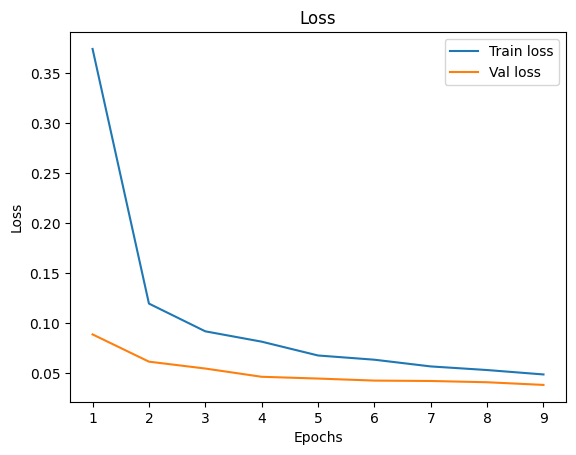

In [24]:
plt.figure()
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(epochs_i, losses_i, label = "Train loss")
plt.plot(epochs_i, val_losses_i, label = "Val loss")
plt.legend()
plt.show()

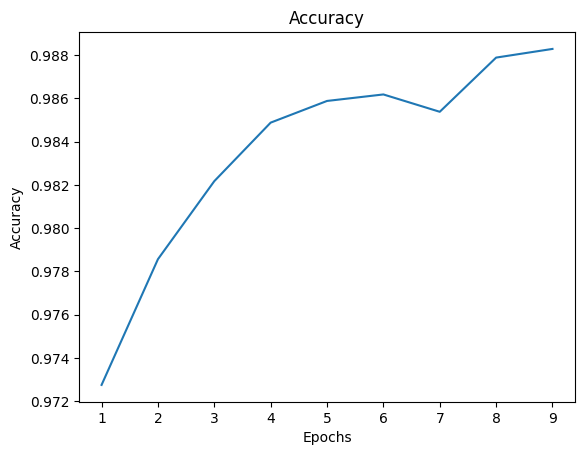

In [33]:
plt.figure()
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.plot(epochs_i, val_accs)
plt.show()

In [66]:
stepi = []
lossi = []

In [67]:
import random
lr = 0.001
momentum = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum, nesterov=True)

for i in range(1000):
  # minibatch construct
  # forward pass
  ix = random.randint(0,len(train_batches))
  out = model(train_batches[ix]['x'])
  loss = F.cross_entropy(out, train_batches[ix]['y'])
  
  #update
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  # scheduler.step()

  stepi.append(i)
  lossi.append(loss.log10().data.item())

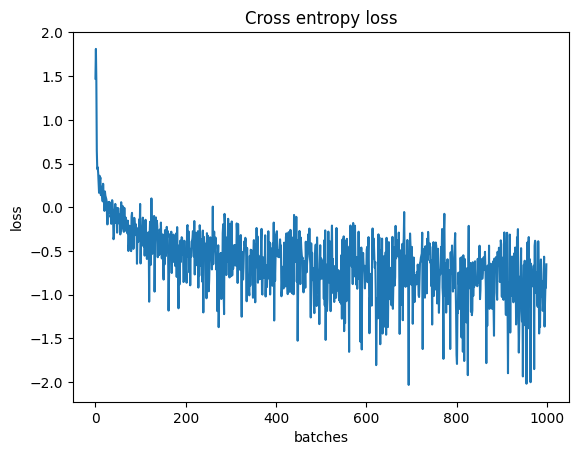

In [81]:
plt.title("Cross entropy loss")
plt.ylabel("loss")
plt.xlabel("batches")
plt.plot(stepi, lossi)

In [25]:
# predict using the model
out = model(torch.tensor([x_test[0]], dtype = torch.float))
predictions = torch.argmax(out, dim=1)
predictions

<ipython-input-25-5e4fdaec4cb8>:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  out = model(torch.tensor([x_test[0]], dtype = torch.float))


tensor([7])

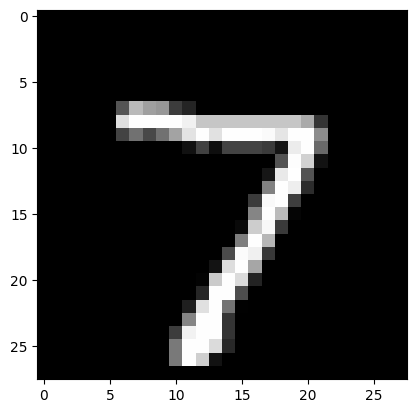

In [27]:
plt.imshow(x_test[0][0], cmap="gray")